In [129]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import GradScaler, autocast
from torch.optim import Adam
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import warnings

warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn.*')

def prepare_and_save_data(data, dep_var, drop_columns, test_size=0.15, random_state=42):
    """
    Prepares and saves data for modeling specifically for a classification task.

    This function prepares the data for modeling by splitting into train, 
    validation, and test sets, scaling features, encoding categorical target for 
    classification, and converting to tensors.

    Parameters:
        data (pandas DataFrame): Dataframe containing all data
        dep_var (str): Name of dependent/target variable column  
        drop_columns (list): Columns to drop from data
        test_size (float): Proportion of data to include in test set
        random_state (int): Random state for splitting data

    Returns:
        X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, 
        X_test_tensor, y_test_tensor (torch tensors): Prepared and split data
    """

    # Drop specified columns
    if drop_columns:
        data = data.drop(columns=drop_columns)
    
    # Select features and target variable
    X = data.drop(columns=[dep_var])
    y = data[dep_var]

    # # Encoding the target variable for classification
    # if data[dep_var].dtype == 'object' or len(y.unique()) > 2:
    #     # Use one-hot encoding if more than two classes or not integer labels
    #     encoder = OneHotEncoder(sparse_output=False)
    #     y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))
    # else:
    #     # Use LabelEncoder for binary classification tasks with integer labels
    #     encoder = LabelEncoder()
    #     y_encoded = encoder.fit_transform(y)

    # Convert target variable to integer labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split data into training+validation sets and test set
    X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y_encoded, test_size=test_size, random_state=random_state)

    # Further split training and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=test_size, random_state=random_state)

    # Scale features
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    X_test_scaled = scaler.transform(X_test)

    # Convert numpy arrays to tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float if y_encoded.ndim == 2 else torch.long)
    X_valid_tensor = torch.tensor(X_valid_scaled, dtype=torch.float)
    y_valid_tensor = torch.tensor(y_valid, dtype=torch.float if y_encoded.ndim == 2 else torch.long)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float if y_encoded.ndim == 2 else torch.long)

    return X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor


import torch
import torch.nn as nn
import torch.nn.functional as F

class ANNModel(nn.Module):
    def __init__(self, n_features, n_classes, num_hidden_layers=2, neurons_per_layer=64,
                 activation_function=torch.nn.ReLU(), dropout_rate=0.1, l1_regularization=0, l2_regularization=0):
        super(ANNModel, self).__init__()

        self.layers = nn.Sequential()
        self.layers.add_module("input", nn.Linear(n_features, neurons_per_layer))
        self.layers.add_module("activation_input", activation_function)  # Correctly instantiate here without calling
        
        # Store regularization parameters
        self.l1_regularization = l1_regularization
        self.l2_regularization = l2_regularization

        for i in range(num_hidden_layers - 1):
            self.layers.add_module(f"hidden_{i}", nn.Linear(neurons_per_layer, neurons_per_layer))
            self.layers.add_module(f"activation_{i}", activation_function)  # Same here, correctly instantiate
            self.layers.add_module(f"dropout_{i}", nn.Dropout(dropout_rate))

        self.layers.add_module("output", nn.Linear(neurons_per_layer, n_classes))
        if n_classes == 1:
            self.output_activation = torch.nn.Sigmoid()
        else:
            self.output_activation = torch.nn.Identity()  # Use Identity because CrossEntropyLoss includes Softmax

        self.init_weights()

    def init_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
                torch.nn.init.zeros_(layer.bias)

    def regularization_loss(self):
        l1_loss = 0
        l2_loss = 0
        for param in self.parameters():
            l1_loss += torch.norm(param, 1)
            l2_loss += torch.norm(param, 2) ** 2
        return self.l1_regularization * l1_loss + self.l2_regularization * l2_loss

    def forward(self, x):
        x = self.layers(x)
        return self.output_activation(x)

def train_ANN_model(model, X_train, y_train, X_valid, y_valid, n_epochs, optimizer=torch.optim.Adam, criterion=torch.nn.CrossEntropyLoss, 
                    batch_size=32, learning_rate=1e-3, patience=10, min_delta=0.0001, max_norm=1.0, num_workers=0, 
                    pin_memory=False, validation_frequency=1, save_directory=None, trial=1):
    """
    Trains an Artificial Neural Network (ANN) model using the specified parameters and data, implementing early stopping and model saving.

    Parameters:
    - model: The neural network model to train.
    - X_train, y_train: Training data and labels as tensors.
    - X_valid, y_valid: Validation data and labels as tensors.
    - n_epochs: Number of epochs to train the model.
    - optimizer: Optimization algorithm to use (default: torch.optim.Adam).
    - criterion: Loss function to use (default: torch.nn.CrossEntropyLoss).
    - batch_size: Number of samples per batch to load (default: 32).
    - learning_rate: Learning rate for the optimizer (default: 1e-3).
    - patience: Number of epochs to wait for improvement before early stopping (default: 10).
    - min_delta: Minimum change in the monitored quantity to qualify as an improvement (default: 0.0001).
    - max_norm: Max norm for gradient clipping (default: 1.0).
    - num_workers: Number of workers for data loading (default: 0).
    - pin_memory: If set to True, tensors will be copied to CUDA pinned memory before returning them (default: False).
    - validation_frequency: Frequency of validation in terms of number of epochs (default: 1).
    - save_directory: Directory to save the trained models (default: None).
    - trial: Identifier for the trial number, used in saving models (default: 1).

    Returns:
    A dictionary containing:
    - 'train_losses': List of average training losses per epoch.
    - 'val_losses': List of average validation losses per epoch.
    - 'train_accuracies': List of training accuracies per epoch.
    - 'val_accuracies': List of validation accuracies per epoch.
    - 'best_val_loss': Best validation loss achieved during training.
    - 'best_accuracy': Best validation accuracy achieved during training.
    - 'early_stopping_counter': Counter indicating the number of consecutive epochs without improvement.
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Handle data preparation
    X_train, y_train = X_train.clone().detach().float().to(device), y_train.clone().detach().long().to(device)
    X_valid, y_valid = X_valid.clone().detach().float().to(device), y_valid.clone().detach().long().to(device)

    # Create data loaders for training and validation
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    valid_dataset = TensorDataset(X_valid, y_valid)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

    # Initialize optimizer and loss function
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    criterion = criterion().to(device)
    scaler = GradScaler()  # for mixed precision training

    best_val_loss = float('inf')
    early_stopping_counter = 0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_accuracy = 0

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            with autocast():  # Automatic mixed precision
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                reg_loss = model.regularization_loss()
                total_loss = loss + reg_loss
            scaler.scale(total_loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += loss.item() * X_batch.size(0)
            correct_train += (y_pred.argmax(1) == y_batch).type(torch.float).sum().item()
            total_train += y_batch.size(0)

        train_losses.append(total_train_loss / total_train)
        train_accuracies.append(correct_train / total_train)

        # Validation
        if epoch % validation_frequency == 0:
            model.eval()
            total_val_loss = 0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for X_batch, y_batch in valid_loader:
                    y_pred = model(X_batch)
                    loss = criterion(y_pred, y_batch)
                    total_val_loss += loss.item() * X_batch.size(0)
                    correct_val += (y_pred.argmax(1) == y_batch).type(torch.float).sum().item()
                    total_val += y_batch.size(0)

            avg_val_loss = total_val_loss / total_val
            val_losses.append(avg_val_loss)
            val_accuracies.append(correct_val / total_val)

            # Check for improvement
            if avg_val_loss < best_val_loss - min_delta:
                best_val_loss = avg_val_loss
                best_accuracy = correct_val / total_val
                early_stopping_counter = 0
                if save_directory:
                    save_path = os.path.join(save_directory, f"ANN_model_trial_{trial}.pt")
                    torch.save(model.state_dict(), save_path)
            else:
                early_stopping_counter += 1
                if early_stopping_counter >= patience:
                    print(f"Early stopping at epoch {epoch}. No improvement in validation loss.")
                    break

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "best_val_loss": best_val_loss,
        "best_accuracy": best_accuracy,
        "early_stopping_counter": early_stopping_counter
    }



import matplotlib.pyplot as plt
import os

def plot_classification_results(train_losses, val_losses, train_accuracies, val_accuracies, trial, save_directory=None):
    """
    Plots the training and validation loss and accuracy curves over epochs for a given trial and optionally saves the plot to a directory.

    Parameters:
    - train_losses (list of float): A list containing the average training loss for each epoch.
    - val_losses (list of float): A list containing the average validation loss for each validation cycle.
    - train_accuracies (list of float): A list containing the training accuracy for each epoch.
    - val_accuracies (list of float): A list containing the validation accuracy for each validation cycle.
    - trial (int): The trial number, used for titling the plot and naming the saved file.
    - save_directory (str, optional): The directory where the plot image will be saved. If None, the plot is not saved.

    This function creates line plots for both loss and accuracy, providing a visual representation of the model's learning process over epochs. The plot is displayed and optionally saved as a PNG file.
    """
    
    plt.figure(figsize=(12, 10))  # Set the figure size for the plot.

    # Create subplot for loss
    plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
    plt.plot(train_losses, label='Train Loss', linewidth=2, color='blue')
    plt.plot(val_losses, label='Valid Loss', linewidth=2, color='red')
    plt.title(f'Training and Validation Loss (Trial {trial+1})', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Create subplot for accuracy
    plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
    plt.plot(train_accuracies, label='Train Accuracy', linewidth=2, color='blue')
    plt.plot(val_accuracies, label='Valid Accuracy', linewidth=2, color='red')
    plt.title(f'Training and Validation Accuracy (Trial {trial+1})', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding

    # Save the plot if a directory is specified
    if save_directory:
        os.makedirs(save_directory, exist_ok=True)
        save_path = os.path.join(save_directory, f"performance_plot_trial_{trial+1}.png")
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")

    plt.show()

import os
import timeit
import random
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, AdamW

def model_save_ANN_classification(X_train, y_train, X_valid, y_valid, n_trials=1, load_directory=None, save_directory=None, plot_loss=True):
    """
    Performs multiple trials of training an ANN for classification with randomly selected hyperparameters,
    saves the trained models, and optionally plots the training and validation loss curves.

    Parameters:
    - X_train, y_train: Training data and labels.
    - X_valid, y_valid: Validation data and labels.
    - n_trials (int): Number of training trials to execute with random hyperparameters.
    - load_directory (str, optional): Directory to load existing models from (not used in this implementation).
    - save_directory (str, optional): Directory to save trained models and results.
    - plot_loss (bool): If True, plots the training and validation loss curves after each trial.

    Returns:
    - all_results_params_df (pandas.DataFrame): DataFrame containing the parameters and results from all trials
      if save_directory is specified. Otherwise, returns a list of dictionaries with the same information.
    """
    if save_directory and not os.path.exists(save_directory):
        os.makedirs(save_directory)
    if load_directory and not os.path.exists(load_directory):
        os.makedirs(load_directory)

    all_results_params = []

    for trial in range(n_trials):
        print(f"Trial {trial + 1} of {n_trials}")

        start = timeit.default_timer()

        # Randomly generate hyperparameters
        num_hidden_layers = random.choice(range(1, 5))
        neurons_per_layer = random.choice([32, 64, 128, 256])
        dropout_rate = random.choice([0.1, 0.2, 0.3, 0.4])
        batch_size = random.choice([32, 64, 128])
        learning_rate = random.choice([0.001, 0.0001, 0.00001])
        activation_function = random.choice([torch.nn.ReLU(), torch.nn.LeakyReLU()])
        optimizer = random.choice([Adam, AdamW])
        criterion = CrossEntropyLoss  # Use CrossEntropyLoss for classification
        n_epochs = random.choice([100, 100, 100])
        patience = random.choice([10, 20])
        min_delta = 0.001
        l1_regularization = 0.0001
        l2_regularization = 0.0001

        # Define the ANN model for classification
        n_classes = len(torch.unique(y_train))
        model = ANNModel(n_features=X_train.shape[1], n_classes=n_classes, num_hidden_layers=num_hidden_layers,
                        neurons_per_layer=neurons_per_layer, activation_function=activation_function,
                        dropout_rate=dropout_rate, l1_regularization=l1_regularization, l2_regularization=l2_regularization)

        # Train the ANN model
        training_results = train_ANN_model(model, X_train, y_train, X_valid, y_valid, n_epochs,
                                           batch_size=batch_size, learning_rate=learning_rate,
                                           patience=patience, min_delta=min_delta, optimizer=optimizer,
                                           criterion=criterion, save_directory=save_directory, trial=trial)

        train_losses, val_losses, train_accuracies, val_accuracies = training_results['train_losses'], training_results['val_losses'], training_results['train_accuracies'], training_results['val_accuracies']
        
        # Optionally plot the loss curves
        if plot_loss:
            plot_classification_results(train_losses, val_losses, train_accuracies, val_accuracies, trial, save_directory=save_directory)

        # Collect results and parameters
        params = {
            "num_hidden_layers": num_hidden_layers,
            "neurons_per_layer": neurons_per_layer,
            "dropout_rate": dropout_rate,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "activation_function": activation_function.__class__.__name__,
            "optimizer": optimizer.__name__,
            "criterion": criterion.__name__,
            "n_epochs": n_epochs,
            "patience": patience,
            "min_delta": min_delta,
            "l1_regularization": l1_regularization,
            "l2_regularization": l2_regularization
        }

        results_params = {**params, "trial": trial + 1, "train_loss": train_losses[-1], "val_loss": val_losses[-1]}
        all_results_params.append(results_params)
        
        if load_directory:
            model_save_path = os.path.join(load_directory, f"ANN_model_trial_{trial}.pt")
            torch.save(model, model_save_path)

        end = timeit.default_timer()
        print(f"Execution Time for Trial {trial + 1}: {end - start} seconds")

    # Save the results to a CSV file if a save directory is specified
    if save_directory:
        all_results_params_df = pd.DataFrame(all_results_params)
        all_results_params_df.to_csv(os.path.join(save_directory, "all_results_params.csv"), index=False)

    return pd.DataFrame(all_results_params) if save_directory else all_results_params

import os
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import pandas as pd

def evaluate_classification_models(X_test, y_test, load_directory=None, save_directory=None, results_file_name='classification_evaluation_results.csv'):
    """
    Loads trained classification models, evaluates them on a test dataset,
    and calculates performance metrics such as accuracy, precision, recall, and F1-score.

    Parameters:
    - X_test (torch.Tensor): The test set features.
    - y_test (torch.Tensor): The test set labels.
    - load_directory (str): Directory from which to load the trained models.
    - save_directory (str, optional): Directory to save the evaluation results.
    - results_file_name (str): File name for saving the evaluation results.

    Returns:
    - results_df (pandas.DataFrame): DataFrame containing the evaluation metrics for each model.
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []

    file_names = os.listdir(load_directory)
    
    for file_name in file_names:
        model_path = os.path.join(load_directory, file_name)
        loaded_model = torch.load(model_path, map_location=device)
        loaded_model.to(device)
        loaded_model.eval()

        X_test_tensor = X_test.float().to(device)
        y_test_tensor = y_test.long().to(device)  # Ensure labels are of type long for classification

        with torch.no_grad():
            y_pred_tensor = loaded_model(X_test_tensor)
            y_pred = torch.argmax(y_pred_tensor, dim=1)  # Convert raw logits to class predictions

        y_true = y_test_tensor.cpu().numpy()
        y_pred = y_pred.cpu().numpy()

        # Compute the metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)

        # Compute the confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred)
        # class_report = classification_report(y_true, y_pred, output_dict=True, zero_division=1)

        # Append the results for this model, including the confusion matrix
        results.append({
            'Model': file_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1_score,
            'Support': support,
            'Confusion Matrix': conf_matrix,
        })

    results_df = pd.DataFrame(results)
    
    if save_directory:
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        results_path = os.path.join(save_directory, results_file_name)
        results_df.to_csv(results_path, index=False)
        print(f"Results saved to {results_path}")
    
    return results_df

import os
import pandas as pd

def execute_and_evaluate_ANN_models(data, dep_var, drop_columns, n_trials, top_k_models, save_directory, load_directory):
    """
    Executes and evaluates ANN models for classification tasks based on a dataset. 
    It involves data preparation, model training with random hyperparameters, and evaluation 
    of models to select the top performers based on classification metrics like accuracy and F1-score.
    
    Parameters:
    - data (pandas.DataFrame): Dataset containing features and the target variable.
    - dep_var (str): Name of the target variable.
    - drop_columns (list of str): Columns to be dropped from the dataset.
    - n_trials (int): Number of training trials with randomly selected hyperparameters.
    - top_k_models (int): Number of top models to select based on performance metrics.
    - save_directory (str): Directory to save training results, model files, and evaluation results.
    - load_directory (str): Directory from which to load trained models for evaluation.
    
    Returns:
    - top_models_df (pandas.DataFrame): DataFrame containing evaluation results of the top-performing models.
    """
    
    if not os.path.exists(save_directory):
        os.makedirs(save_directory, exist_ok=True)

    # Prepare data and split into training, validation, and test sets
    X_train, y_train, X_valid, y_valid, X_test, y_test = prepare_and_save_data(
        data, dep_var, drop_columns, test_size=0.2, random_state=42)

    # Train models and save results
    model_save_ANN_classification(X_train, y_train, X_valid, y_valid, n_trials=n_trials, load_directory=load_directory, save_directory=save_directory, plot_loss=True)

    # Evaluate models on the test set and save evaluation results
    evaluate_results_df = evaluate_classification_models(X_test, y_test, load_directory=load_directory, save_directory=save_directory)
    print("Evaluation results:")
    
    # Select the top k models based on a performance metric like accuracy
    if 'Accuracy' in evaluate_results_df.columns:
        top_models_df = evaluate_results_df.nlargest(top_k_models, 'Accuracy')
    else:
        print("Accuracy column not found in evaluate_results_df.")
        top_models_df = pd.DataFrame()

    print("Top models based on Accuracy:")
    print(top_models_df)

    # Optionally save the top models' evaluation results
    top_models_df.to_csv(os.path.join(save_directory, "top_models_evaluation.csv"), index=False)

    return top_models_df


In [130]:
df = pd.read_csv('/home/predict_price/stock_price/Data_Science_Project/Data/iris.csv')

# Preprocess a categorical column (ordinal variable) using mapping
# Define a dictionary to map the categorical values to integers
mapping = {'setosa': 0, 'versicolor': 1, 'virginica': 2}

# Use the map method to apply the dictionary to the column
df['species'] = df['species'].map(mapping)

Trial 1 of 3
Plot saved to /home/predict_price/stock_price/Data_Science_Project/ANN_Model/ANN_Classification/save_directory/performance_plot_trial_1.png


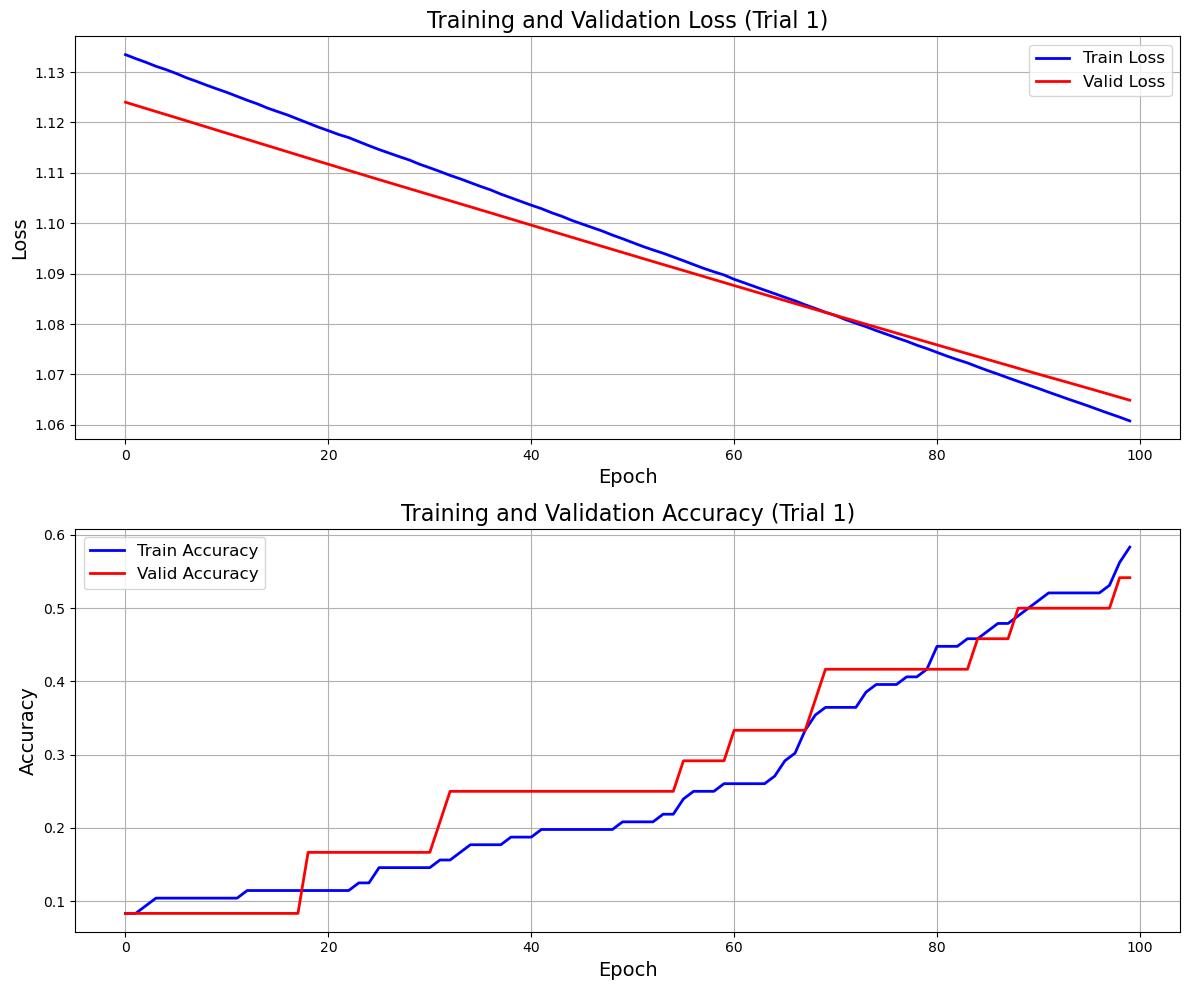

Execution Time for Trial 1: 0.9807517640001606 seconds
Trial 2 of 3
Plot saved to /home/predict_price/stock_price/Data_Science_Project/ANN_Model/ANN_Classification/save_directory/performance_plot_trial_2.png


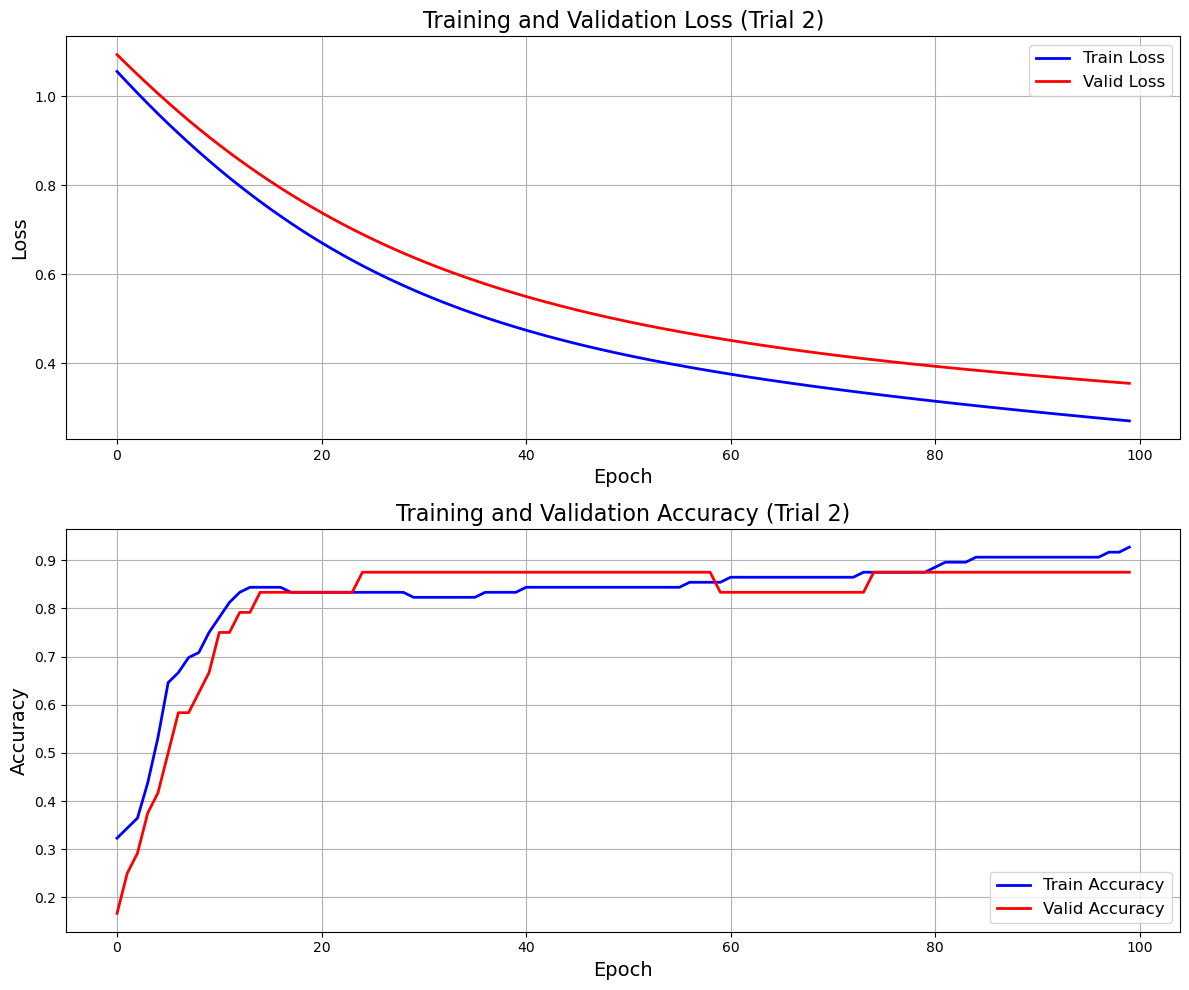

Execution Time for Trial 2: 0.5278093770029955 seconds
Trial 3 of 3
Plot saved to /home/predict_price/stock_price/Data_Science_Project/ANN_Model/ANN_Classification/save_directory/performance_plot_trial_3.png


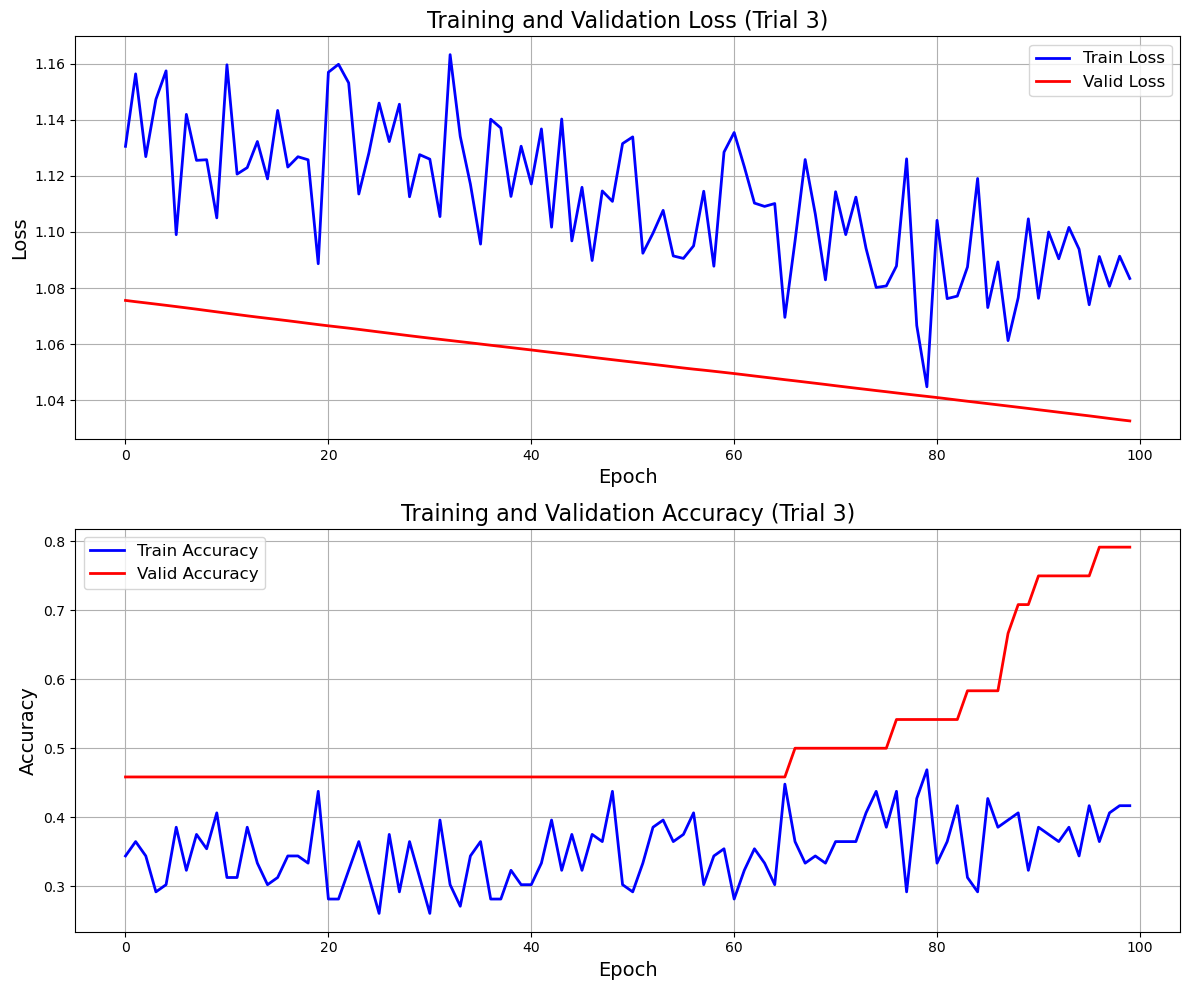

Execution Time for Trial 3: 3.8519773980078753 seconds
Results saved to /home/predict_price/stock_price/Data_Science_Project/ANN_Model/ANN_Classification/save_directory/classification_evaluation_results.csv
Evaluation results:
Top models based on Accuracy:
                  Model  Accuracy  Precision    Recall  F1-Score Support  \
2  ANN_model_trial_1.pt  0.966667   0.969444  0.966667  0.966411    None   

                      Confusion Matrix  
2  [[10, 0, 0], [0, 8, 1], [0, 0, 11]]  


In [131]:
from sklearn.preprocessing import LabelEncoder
n_trials = 3
top_k_models = 1
encoder = LabelEncoder()
load_directory = '/home/predict_price/stock_price/Data_Science_Project/ANN_Model/ANN_Classification/load_directory'
save_directory = '/home/predict_price/stock_price/Data_Science_Project/ANN_Model/ANN_Classification/save_directory'
top_models_df = execute_and_evaluate_ANN_models(df, 'species', drop_columns=[], n_trials=n_trials, top_k_models=top_k_models, 
load_directory=load_directory, save_directory=save_directory)